In [35]:
import matplotlib
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold as SKF
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import roc_auc_score as AUC

# Supervised classification by covariate shift adaption

In this notebook I'm showing one method to correct for covariate-shift, where there is a difference in the distribution of the training and test data in a machine learning problem. 

The covariates are some features (often represented by $X$) with an associated response variable $y$, and our goal in machine-learning is to compute $p(y|x,h)$ using some model (or hypothesis) $h$. Covariate shift refers to a situation where some of the input features during test time ($X_{tr}$) follow a different distribution compared to the training data ($X_{te}$). The method discussed here comes from refs [1-2].

Using cross-validation we can estimate the performance, or loss, of our trained model on data from the training distribution. However, as the test data comes unlabelled we cannot use it directly with cross-validation in the same way, and so an accurate estimate of the model's performance on real test data is more difficult to achieve. The expected loss (l) of a model on the test data is written, $E[l(f(X_{te}), y)]$ where $f(x)$ maps X to $\hat{y}$. It is shown in [1] that this is related to the expected training loss by a factor $\beta = \frac{p(X_{te})}{p(X_{tr})}$, i.e.

$E\left[l(f(X_{te}), y)\right] = E\left[\frac{p(X_{te})}{p(X_{tr})}\,l(f(X_{tr}), y)\right]$.

What does this mean? First, $p(X_{te})$ being on the numerator of $\beta$ means that points in the training data that are close to high-density regions of the test data will be weighted-up. This makes a lot of sense intuitively. Second, the $p(X_{tr})$ term on the demoninator of $\beta$ actually reduces the contribution from training points that are in a high-density region of the training data. Therefore in a region of feature-space where the training and test distributions are very similar $\beta$ will be close to one, and in more imbalanced regions $\beta$ should vary compensate.

How to actually use this? There are different ways to make use of this discussed in the literature. One method is using kernel means matching, to match the differing distributions. Another simpler method is by training a discriminative classifier to learn $p(X_{tr}|D)$, for some data $D$.

For an example of this in action, see below!

##### References 
[1] Shimodaira, H. (2000). Improving predictive inference under covariate shift by weighting the log-likelihood function. Journal of Statistical Planning and Inference, 90, 227–244.<br/>
[2] Bickel, S. *et al.* (2009). Discriminative Learning Under Covariate Shift. Journal of Machine Learning Research, 10, 2137-2155<br/>

# Example
We make some data with a clear covariate shift. The labelled training data here is claled $Z$, while the data we want to predict is called $X$.

In [38]:
# make some data which has a clear covariate shift
n_samples_Z = 1000
n_samples_X = 100
x = 11*np.random.random(n_samples_Z)- 6.0
y = x**2 + 10*np.random.random(n_samples_Z) - 5
Z = np.c_[x, y]
    
x = 2*np.random.random(n_samples_X) - 6.0
y = x**2 + 10*np.random.random(n_samples_X) - 5
X = np.c_[x, y]

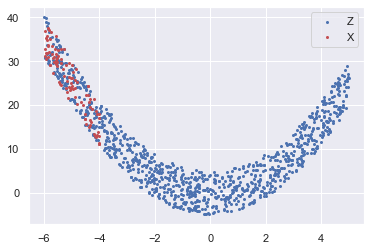

In [39]:
# plot the data
plt.scatter(Z[:,0], Z[:,1], marker='o', s=4, c='b', label='Z')
plt.scatter(X[:,0], X[:,1], marker='o', s=4, c='r', label='X')
plt.legend()

First we concatenate the training and test data (rbind for R users) into a new dataset $XZ$, and assign labels 1 and 0 to the training and test data respectively. Then we use this to train a classifier to tell the difference between the training and test data. We'll output the ROC-AUC metric for our classifier as an estimate how much covariate shift this data has.

In [40]:
X = pd.DataFrame(X)
Z = pd.DataFrame(Z)
X['is_z'] = 0 # 0 means test set
Z['is_z'] = 1 # 1 means training set
XZ = pd.concat( [X, Z], ignore_index=True, axis=0 )

labels = XZ['is_z'].values
XZ = XZ.drop('is_z', axis=1).values
X, Z = X.values, Z.values

In [45]:
# can use a non-linear learner, but make sure to restrict how 
# much it can learn or it will discriminate too well.
clf = RFC(max_depth=2)
# because we can see a learn divide in the above data we 
# could simply use logistic regression here.
# clf = LR()

predictions = np.zeros(labels.shape)
skf = SKF(n_splits=20, shuffle=True, random_state=0)
for fold, (train_idx, test_idx) in enumerate(skf.split(XZ, labels)):
    print('Training discriminator model for fold {}'.format(fold))
    X_train, X_test = XZ[train_idx], XZ[test_idx]
    y_train, y_test = labels[train_idx], labels[test_idx]
        
    clf.fit(X_train, y_train)
    probs = clf.predict_proba(X_test)[:, 1]
    predictions[test_idx] = probs

Training discriminator model for fold 0
Training discriminator model for fold 1
Training discriminator model for fold 2
Training discriminator model for fold 3
Training discriminator model for fold 4
Training discriminator model for fold 5
Training discriminator model for fold 6
Training discriminator model for fold 7
Training discriminator model for fold 8
Training discriminator model for fold 9
Training discriminator model for fold 10
Training discriminator model for fold 11
Training discriminator model for fold 12
Training discriminator model for fold 13
Training discriminator model for fold 14
Training discriminator model for fold 15
Training discriminator model for fold 16
Training discriminator model for fold 17
Training discriminator model for fold 18
Training discriminator model for fold 19


In [46]:
print('ROC-AUC for X and Z distributions:', AUC(labels, predictions))

ROC-AUC for X and Z distributions: 0.912965


In the *predictions* array, we just computed the probability of a sample in the full dataset being sample taken from the training distribution ($Z$). We'll call this $p(Z|D)$. Next we'll use the relationship that $p(Z|D) = 1 - p(X|D)$ to estimate $\beta$ for our training samples,

$\beta_i = \frac{p_i(X|D)}{p_i(Z|D)} = \frac{1 - p_i(Z|D)}{p_i(Z|D)} = \frac{1}{p(Z|D)} - 1$.

So we now have a method to convert the probability of each point belonging to the training distribution into our sample weights $\beta$. Let's see what these weights look like for the toy problem above...

/Users/liaoc/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


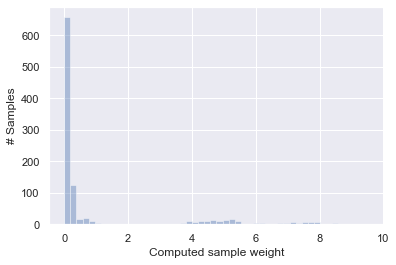

In [47]:
# first, isolate the training part (recall we joined them above)
predictions_Z = predictions[len(X):]
weights = (1./predictions_Z) - 1. 
weights /= np.mean(weights) # we do this to re-normalize the computed log-loss
plt.xlabel('Computed sample weight')
plt.ylabel('# Samples')
sns.distplot(weights, kde=False)

A lot of the training samples have a very low weight. Looking again at the distributions of $X$ and $Z$ above this makes sense: there is a lot less test data than training data, and it is all confined to one corner of the training distribution. 

Finally we plot the distributions of the training and test data again, but scale the size of the training points by their weight.

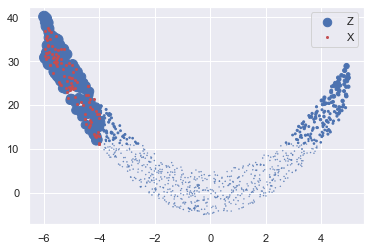

In [48]:
Zsize = 0.1 + weights*15
plt.scatter(Z[:,0], Z[:,1], marker='o', s=Zsize, c='b', label='Z')
plt.scatter(X[:,0], X[:,1], marker='o', s=4, c='r', label='X')
plt.legend()

Looks good - the training data to the left, closest to the test data is being being weighted more heavily. Now *weights* can be used with any classifier that takes a *sample_weights* argument to get accurate cross-validation scores for the test distribution.